Shape determinants of an Aneurysm.

volume (V) ----------------------------------------------------------------
max diameter (Dm)
surface area (S)   ----------------------------------------------------------------
height (H) 
neck diameter (Dn) 
undulation index (UI) ----------------------------------------------------------------
aspect ratio (AR) : (H/Dn)  
ellipticity index (EI) ----------------------------------------------------------------
nonsphericity index (NSI) ----------------------------------------------------------------
conicity parameter (CP) 
bottleneck factor (BF) 
mean curvature norm (MLN) ----------------------------------------------------------------
gaussian curvature norm (GLN) ----------------------------------------------------------------

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import rtree
import math
import statistics
from trimesh.curvature import discrete_gaussian_curvature_measure,  discrete_mean_curvature_measure, sphere_ball_intersection
import networkx as nx


In [52]:
print(trimesh.__version__)

4.2.0


In [53]:
df_cpc = pd.read_csv("./AneuX dataset/clinical-per-cut.csv")
df_clinical = pd.read_csv("./AneuX dataset/clinical.csv")
df_mpc = pd.read_csv("./AneuX dataset/per_source/area-005/morpho-per-cut-flat.csv")

dome_mesh = trimesh.load_mesh("./dome_model.stl")
dome_mesh_v_1 = trimesh.load_mesh("./V-1.stl")
# Print the edges
print("Edges:")
print(dome_mesh.edges)

# Print the faces
print("Faces:")
print(dome_mesh.faces)

# Print the vertices
print("Vertices:")
print((dome_mesh.vertices))

Edges:
[[   0    1]
 [   1    2]
 [   2    0]
 ...
 [ 996 1198]
 [1198 1031]
 [1031  996]]
Faces:
[[   0    1    2]
 [   3    4    5]
 [   2    1    3]
 ...
 [1146 1031 1198]
 [1031 1146 1109]
 [ 996 1198 1031]]
Vertices:
[[43.38034058 45.13111877 39.1157341 ]
 [43.32600021 45.17370224 39.13330078]
 [43.38864136 45.18005753 39.16732025]
 ...
 [38.41059875 49.1012001  42.75749969]
 [38.24670029 48.92760086 42.77939987]
 [38.40069962 48.99470139 42.96290207]]


In [26]:
d=dome_mesh.show(smooth=True, background_color=(0.7, 0.7, 0.9), figsize=(1200, 800))
dv1=dome_mesh_v_1.show(smooth=True, background_color=(0.7, 0.7, 0.9), figsize=(1200, 800))
dome_mesh.show(smooth=True, background_color=(0.7, 0.7, 0.9), figsize=(1200, 800))

In [27]:
dome_mesh_v_1.show(smooth=True, background_color=(0.7, 0.7, 0.9), figsize=(1200, 800))

In [28]:
dome_mesh_hull = trimesh.convex.convex_hull(dome_mesh)
print("This is the convex hull of the aneurysm V-0")
dome_mesh_v1_hull = trimesh.convex.convex_hull(dome_mesh_v_1)


dome_mesh_hull.show()

This is the convex hull of the aneurysm V-0


In [29]:
dome_mesh_v1_hull.show()

In [31]:
def Undulation_index(x):
   return (1 - (x.volume/ x.convex_hull.volume))

UI_v0 = Undulation_index(dome_mesh)
print("This is Undulation Index for v0:",UI_v0)
UI_v1 = Undulation_index(dome_mesh_v_1)
print("This is Undulation Index for v1:",UI_v1)


This is Undulation Index for v0: 0.10071186663314602
This is Undulation Index for v1: 0.07831584088335763


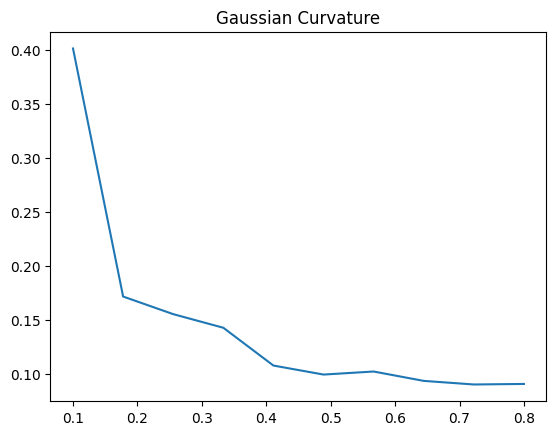

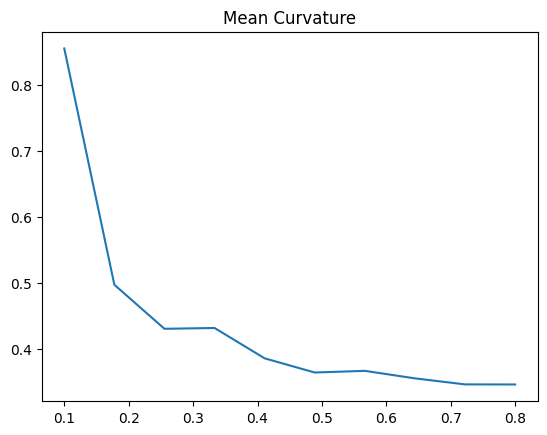

[0.40161269 0.17158989 0.15526495 0.14264294 0.10759782 0.09923777
 0.10205981 0.09337378 0.09004359 0.09053571]


In [46]:
# vn = dome_mesh.vertex_normals
# mean_curvature = trimesh.curvature.discrete_mean_curvature_measure(dome_mesh.vertices, vn,radius=0.1)
# mean_curvature

radii = np.linspace(0.1, 0.8, 10)
gauss = np.array([discrete_gaussian_curvature_measure(dome_mesh, dome_mesh.vertices, r)/sphere_ball_intersection(1, r) for r in radii])
mean_curv = np.array([discrete_mean_curvature_measure(dome_mesh, dome_mesh.vertices, r)/sphere_ball_intersection(1, r) for r in radii])

plt.figure()
plt.plot(radii, gauss.mean(axis=1))
plt.title('Gaussian Curvature')
plt.show()

plt.figure()
plt.plot(radii, mean_curv.mean(axis=1))
plt.title('Mean Curvature')
plt.show()
print(gauss.mean(axis=1))

In [47]:
print(radii)

[0.1        0.17777778 0.25555556 0.33333333 0.41111111 0.48888889
 0.56666667 0.64444444 0.72222222 0.8       ]


In [49]:

# gc_array=discrete_gaussian_curvature_measure(dome_mesh,dome_mesh.vertices,0)
# print(statistics.mean(gc_array), "mean of the gaussian curvature")
# #Normalize the gaussian curvature with a sphere of similar volume

# pi = math.pi

# # Solve for the radius
# sphere_radius = np.cbrt(dome_mesh.volume / (4/3 * pi))

# #theoretically sphere curvature is 1/r^2
# theoretical_curvature = 1 / (sphere_radius**2)
# normalized_curvature = gc_array / theoretical_curvature
# print(statistics.mean(normalized_curvature))

def calculate_GLN_MLN_curvature_and_normalize(dome_mesh, target_volume):
  """
  Calculates discrete Gaussian curvature, normalizes against a target sphere,
  and returns potential estimates for MLN and GLN.

  Args:
      dome_mesh: A trimesh mesh object representing the aneurysm dome.
      target_volume: The volume of the target sphere for normalization (e.g., 230).

  Returns:
      A tuple containing:
          normalized_curvature: Array of normalized curvature values.
          potential_mln: Potential estimate of Mean curvature Local Normalized.
          potential_gln: Potential estimate of Gaussian curvature Local Normalized.
  """

  # Calculate sphere radius
  pi = math.pi
  sphere_radius = np.cbrt(target_volume / (4/3 * pi))

  # Get vertices and calculate curvature
  vertices = dome_mesh.vertices
  gaussian_curvature = trimesh.curvature.discrete_gaussian_curvature_measure(dome_mesh, vertices, radius=0.1)

  # Normalize curvature
  theoretical_curvature = 1 / (sphere_radius**2)
  normalized_curvature = gaussian_curvature / theoretical_curvature

  # Potential estimates for MLN and GLN (assuming uniform distribution)
  potential_mln = np.mean(normalized_curvature)
  potential_gln = np.mean(normalized_curvature**2)

  return potential_mln, potential_gln
  # return normalized_curvature if you want to 

# Assuming your dome mesh is loaded as dome_mesh
potential_mln, potential_gln = calculate_GLN_MLN_curvature_and_normalize(dome_mesh, target_volume=dome_mesh.volume)
potential_mln_v1, potential_gln_v1 = calculate_GLN_MLN_curvature_and_normalize(dome_mesh_v_1, target_volume=dome_mesh_v_1.volume)

print( potential_mln, potential_gln, "these are MLN_v0 and GLN_v0 estimates")
print( potential_mln_v1, potential_gln_v1, "these are MLN_v1 and GLN_v1 estimates")


0.121206263950124 0.6282079111397763 these are MLN_v0 and GLN_v0 estimates
0.12155522242598872 0.10717958722566873 these are MLN_v1 and GLN_v1 estimates


In [36]:
def Ellipcity_index(x):
    a = np.cbrt(18* math.pi)
    b = (np.cbrt(x.convex_hull.volume) ** 2)/(x.convex_hull.area)
    return 1 - a*b

EI = Ellipcity_index(dome_mesh)
EI_v1 = Ellipcity_index(dome_mesh_v_1)
print(EI, "is the Ellicpcity index of the Aneurysm v0")
print(EI_v1, "is the Ellicpcity index of the Aneurysm v1")

0.26348889745100845 is the Ellicpcity index of the Aneurysm v0
0.2651896655580046 is the Ellicpcity index of the Aneurysm v1


In [39]:
def Non_Sphericity_index(x):
    a = np.cbrt(18* math.pi)
    b = (np.cbrt(x.volume) ** 2)/(x.area)
    return 1 - a*b

NSI = Non_Sphericity_index(dome_mesh)
NSI_v1 = Non_Sphericity_index(dome_mesh_v_1)
print(NSI, "is the Non sphericity index of the Aneurysm v0")
print(NSI_v1, "is the Non sphericity index of the Aneurysm v1")



0.30125789614415066 is the Non sphericity index of the Aneurysm v0
0.29207295167527125 is the Non sphericity index of the Aneurysm v1


In [44]:
def Volumetric_shape_dets(x):
#     print("These are teh voolumetric shape determinants that need to be calculated for every patients DOME!!!")
#     print("We take the dome model, its convex hull as primary models for these shape determinants")

    UI = Undulation_index(x)
    potential_MLN, potential_GLN = calculate_GLN_MLN_curvature_and_normalize(x, target_volume=x.volume)
    EI = Ellipcity_index(x)
    NSI = Non_Sphericity_index(x)
    V = x.volume
    S = x.area

   
    print("Undulation Index: ", UI)
    print("potential_Mean curvature Normal: ", potential_MLN)
    print("potential_Gaussian Normal Curvature: ", potential_GLN)
    print("Ellipcity Index: ", EI)
    print("Non-sphercicty Index: ",NSI)
    print("Volume of the aneurysm dome: ",V )
    print("Surface are of the aneurysm dome: ",S)
    
    

In [45]:

print("\n\n")
print("The volumetric determinants of our aneurysm dome v0:\n\n")
Volumetric_shape_dets(dome_mesh)

print("\n\n")
print("The volumetric determinants of our aneurysm dome v1:\n\n")
Volumetric_shape_dets(dome_mesh_v_1)





The volumetric determinants of our aneurysm dome v0:


Undulation Index:  0.10071186663314602
potential_Mean curvature Normal:  0.06330338525631617
potential_Gaussian Normal Curvature:  0.38579034373944765
Ellipcity Index:  0.26348889745100845
Non-sphercicty Index:  0.30125789614415066
Volume of the aneurysm dome:  124.72119282146805
Surface are of the aneurysm dome:  137.1252344950458



The volumetric determinants of our aneurysm dome v1:


Undulation Index:  0.07831584088335763
potential_Mean curvature Normal:  0.009104095673509725
potential_Gaussian Normal Curvature:  0.002638335381394338
Ellipcity Index:  0.2651896655580046
Non-sphercicty Index:  0.29207295167527125
Volume of the aneurysm dome:  119.8169875117118
Surface are of the aneurysm dome:  131.77445154031437


In [54]:
print(df_cpc.shape,df_clinical.shape,df_mpc.shape)

(3422, 12) (750, 11) (2836, 173)


In [55]:
print(df_cpc.columns,"\n\n",
      df_clinical.columns, "\n\n",df_mpc.columns)

Index(['source', 'dataset', 'cutType', 'hospital', 'status', 'location',
       'side', 'sex', 'age', 'patientID', 'vesselFileID', 'cutToShow'],
      dtype='object') 

 Index(['source', 'dataset', 'hospital', 'status', 'location', 'side', 'sex',
       'age', 'patientID', 'vesselFileID', 'cutToShow'],
      dtype='object') 

 Index(['source', 'dataset', 'cutType', 'curvature.gauss.-L2N',
       'curvature.gauss.H', 'curvature.gauss.L2N', 'curvature.gauss.L2NCH',
       'curvature.mean.-L2N', 'curvature.mean.H', 'curvature.mean.L2N',
       ...
       'zmi_surf.energy.n11', 'zmi_surf.energy.n12', 'zmi_surf.energy.n13',
       'zmi_surf.energy.n14', 'zmi_surf.energy.n15', 'zmi_surf.energy.n16',
       'zmi_surf.energy.n17', 'zmi_surf.energy.n18', 'zmi_surf.energy.n19',
       'zmi_surf.energy.n20'],
      dtype='object', length=173)


In [56]:
print(len(df_cpc['dataset'].unique()), len(df_clinical['dataset'].unique()), len(df_mpc['dataset'].unique()))

750 750 750


In [57]:
df_mpc_cpc =pd.merge(df_cpc,df_mpc,on = ["dataset","cutType"], how="outer")
df_mpc_cpc


,source_x,dataset,cutType,hospital,status,location,side,sex,age,patientID,...,zmi_surf.energy.n11,zmi_surf.energy.n12,zmi_surf.energy.n13,zmi_surf.energy.n14,zmi_surf.energy.n15,zmi_surf.energy.n16,zmi_surf.energy.n17,zmi_surf.energy.n18,zmi_surf.energy.n19,zmi_surf.energy.n20
0,aneurist,ANSYS_UNIGE_09,cut1,Geneva,unruptured,MCA bif,right,female,73.5,74s/Ab29lu3hxEw2q/vRzlivi8VT0e7FvvRUYTkz+349ba...,...,30.6440,34.1297,36.9670,38.8231,40.5633,41.9360,43.5888,45.3810,47.9954,51.0830
1,aneurist,ANSYS_UNIGE_09,dome,Geneva,unruptured,MCA bif,right,female,73.5,74s/Ab29lu3hxEw2q/vRzlivi8VT0e7FvvRUYTkz+349ba...,...,20.9418,24.2035,25.3240,26.5023,27.8519,29.7922,31.5633,34.0377,35.2758,36.5486
2,aneurist,ANSYS_UNIGE_09,ninja,Geneva,unruptured,MCA bif,right,female,73.5,74s/Ab29lu3hxEw2q/vRzlivi8VT0e7FvvRUYTkz+349ba...,...,19.9257,23.2850,24.1501,25.4170,26.6573,28.4424,29.9027,32.7034,33.6456,35.0243
3,aneurist,ANSYS_UNIGE_16,cut1,Geneva,ruptured,BA tip,midline,female,50.8,fq4CZMnPbaW+HkqwUo0zeFSRQgjENKAWZ0v0NvJVXbqqDr...,...,35.7618,37.7493,40.0477,42.2092,44.2713,46.3125,48.9756,50.8039,54.4488,56.8669
4,aneurist,ANSYS_UNIGE_16,dome,Geneva,ruptured,BA tip,midline,female,50.8,fq4CZMnPbaW+HkqwUo0zeFSRQgjENKAWZ0v0NvJVXbqqDr...,...,20.8164,22.1336,24.3699,25.8460,27.3948,28.7912,30.6561,32.5025,33.9450,35.3660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3417,hug2016,p555_AAQAExkGDAQBFw8BAgQcFxwW_TB,cut0,Geneva,unruptured,SCA,left,male,55.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3418,hug2016,p555_AAQAExkGDAQBFw8BAgQcFxwW_TB,cut1,Geneva,unruptured,SCA,left,male,55.8,NaN,...,30.2896,32.9288,37.0354,39.0979,42.1475,43.8308,45.3189,46.8733,48.5398,50.4951
3419,hug2016,p555_AAQAExkGDAQBFw8BAgQcFxwW_TB,cut2,Geneva,unruptured,SCA,left,male,55.8,NaN,...,48.2364,49.8903,51.2432,54.4174,57.0064,61.6850,65.6429,71.1447,76.2417,81.7724
3420,hug2016,p555_AAQAExkGDAQBFw8BAgQcFxwW_TB,dome,Geneva,unruptured,SCA,left,male,55.8,NaN,...,20.8420,22.2618,24.0544,25.4506,27.0249,28.8977,30.6904,32.2157,33.8155,35.3325


In [49]:
df_mpc_cpc.to_csv("./merged_aneurysm_data.csv")

In [82]:
cols=list(df_mpc_cpc.columns)
print(len(cols))
null_counts=df_mpc_cpc.isna().sum()
with pd.option_context('display.max_rows', 183):
    print(null_counts)



183
source_x                    0
dataset                     0
cutType                     0
hospital                    0
status                     75
location                    0
side                      714
sex                         0
age                       160
patientID                 565
vesselFileID                0
cutToShow                   0
source_y                  586
curvature.gauss.-L2N     1922
curvature.gauss.H        1922
curvature.gauss.L2N      1922
curvature.gauss.L2NCH    1922
curvature.mean.-L2N      1922
curvature.mean.H         1922
curvature.mean.L2N       1922
curvature.mean.L2NCH     1922
gi.shape.AR              1922
gi.shape.BF              1922
gi.shape.CP              1922
gi.shape.EI              1922
gi.shape.NSI             1922
gi.shape.UI              1922
gi.size.Dmax             1922
gi.size.Dn               1922
gi.size.H                1922
gi.size.S                1922
gi.size.V                1922
gi.size.aSz              1922
writhe

In [89]:
df_mpc_cpc['patientID'].value_counts()

patientID
Y3v6alEzFEUzNYeuyno6cPvYK+w9aq+LkFB3tuu4tu11aqSyvcmJlrZsInQXfWiU    35
STRHvYH6PCoJjbIWhVXdkaFW2LMnt2Bwq5OAvHhGXVovHEvwGENb4ESG723mrH3X    25
wxHsruUyeopiuD+ICF51UgH9djU6/tlkbKxiUOBsiLI0/FVKadLsKxrN16BI7VrF    25
ZhXFiksZ/xAVELuI5KmDn219pUQIx620gFSXyMBCgcOTLCNRaFHXl08UDXo7I2bU    25
gCJQxPLMhVQrjnqtclZ8P+BKu7tD8kzgtkNiK5jeG198Cdx+fOwC1oLZfYE1n72J    20
                                                                    ..
w7yVZKC3NRhvcRuRkIOwGtpqnjQhdllZAdPH8dVa3pXWfvR3xi7zGbiAt4LhPHWS     3
dDvP5auMQCw/T7820R9vFYH9cwl9QAJO1JsKtKTYDyzGRcbdcZ+l3Hg1026IZYcE     3
EpRBRsvqB6iaoQipm9fPOV5+eyx38NexuL69vY3ckKVn/1Kn4KjCm4P2L/tZd24j     3
KZ3BiZUvOmA6uG8qfvgVfo3T5t5yoe+AHdQL93FAGjjo3FG6EqVm1Uw1oVQSWKUh     3
C8AdhJIc59j1JX4VjqK4IhnkyGVyiJI0Cgxne/8YSQ1In/RiE9AmRJpxCkt5fa9V     3
Name: count, Length: 509, dtype: int64

In [91]:
cols


['source_x',
 'dataset',
 'cutType',
 'hospital',
 'status',
 'location',
 'side',
 'sex',
 'age',
 'patientID',
 'vesselFileID',
 'cutToShow',
 'source_y',
 'curvature.gauss.-L2N',
 'curvature.gauss.H',
 'curvature.gauss.L2N',
 'curvature.gauss.L2NCH',
 'curvature.mean.-L2N',
 'curvature.mean.H',
 'curvature.mean.L2N',
 'curvature.mean.L2NCH',
 'gi.shape.AR',
 'gi.shape.BF',
 'gi.shape.CP',
 'gi.shape.EI',
 'gi.shape.NSI',
 'gi.shape.UI',
 'gi.size.Dmax',
 'gi.size.Dn',
 'gi.size.H',
 'gi.size.S',
 'gi.size.V',
 'gi.size.aSz',
 'writhe.original.H',
 'writhe.original.mean',
 'writhe.original.std',
 'writhe.L1norm.H',
 'writhe.L1norm.mean',
 'writhe.L1norm.std',
 'writhe.L2.H',
 'writhe.L2.mean',
 'writhe.L2.std',
 'zmi_surf.0.0',
 'zmi_surf.1.1',
 'zmi_surf.10.0',
 'zmi_surf.10.10',
 'zmi_surf.10.2',
 'zmi_surf.10.4',
 'zmi_surf.10.6',
 'zmi_surf.10.8',
 'zmi_surf.11.1',
 'zmi_surf.11.11',
 'zmi_surf.11.3',
 'zmi_surf.11.5',
 'zmi_surf.11.7',
 'zmi_surf.11.9',
 'zmi_surf.12.0',
 'zmi_s